## Mestopy Demo-Notebook


In [1]:
# import modules
import numpy as np
import sounddevice as sd
from matplotlib import pyplot as plt
from scipy import signal
import pyfar

# import mestopy
from mestopy.mestopy import MeasurementChain, deconv

#### Demo: basic functionality of Measurement Chain

In [2]:
# initialise measurement chain @fs=44100
fs = 48000
chain = MeasurementChain(fs)

In [3]:
# reset MeasurementChain refs, in case you run this cell multiple times
chain.reset_devices()

# generate a flat signal
sig = pyfar.Signal(np.full(int(fs/2), 1.0), fs, domain='freq')

# add these signals as devices to the measurement chain; attention: Device 1 is added twice by "mistake"
chain.add_device(sig, sens=1.0, device_name='Device 1') 
chain.add_device(sig, sens=1.0, device_name='Device 1')
chain.add_device(sig, sens=2.0, device_name='Device 2')
chain.add_device(sig, sens=0.5, device_name='Device 3')

# print measurement chain __repr__
print(chain)

# print names of devices in measurement chain
print(chain.list_devices())

# remove double added Device 1 from measurement chain
chain.remove_device(1)

# print names of devices in measurement chain after removing
print(chain.list_devices())

# get the freq-response of whole measurement chain as pyfar.Signal
chain.freq()

# get the freq-response of specific device in measurement chain as pyfar.Signal
chain.device_freq(1)

measurement chain with 4 devices @ 48000 Hz sampling rate.
# 1: Device 1 defined by 24000 freq-bins, sensitivity=1.0
# 2: Device 1 defined by 24000 freq-bins, sensitivity=1.0
# 3: Device 2 defined by 24000 freq-bins, sensitivity=2.0
# 4: Device 3 defined by 24000 freq-bins, sensitivity=0.5

['Device 1', 'Device 1', 'Device 2', 'Device 3']
['Device 1', 'Device 2', 'Device 3']


freq domain energy Signal:
(1,) channels with 47998 samples @ 48000 Hz sampling rate and none FFT normalization

<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

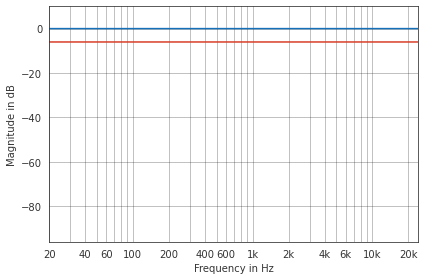

In [4]:
# plot freq-response of whole measurement chain
fig1 = pyfar.plot.line.freq(chain.freq())

# plot freq-response of element 1 of the measurement chain
pyfar.plot.line.freq(chain.device_freq(2))

['Device 1', 'Device 2', 'Device 3']
['Device 1', 'Device 2']


<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

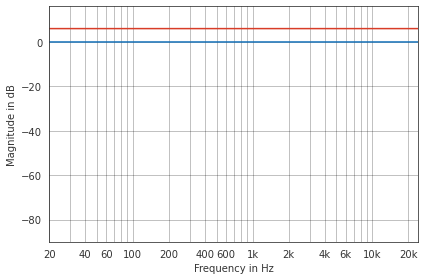

In [5]:
# remove devices from measurement chain by name
print(chain.list_devices())
chain.remove_device('Device 3')
print(chain.list_devices())

# plot freq-response of whole measurement chain
fig1 = pyfar.plot.line.freq(chain.device_freq('Device 1'))
# invert ref-response and plot again
pyfar.plot.line.freq(chain.freq())

In [6]:
chain.add_device()
chain

measurement chain with 3 devices @ 48000 Hz sampling rate.
# 1: Device 1 defined by 24000 freq-bins, sensitivity=1.0
# 2: Device 2 defined by 24000 freq-bins, sensitivity=2.0
# 3:  defined by 24000 freq-bins, sensitivity=1

['Device 1', 'Device 2', '']


<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

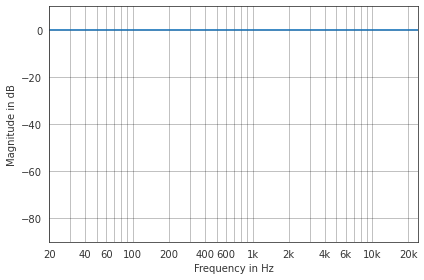

In [7]:
print(chain.list_devices())
pyfar.plot.line.freq(chain.device_freq(''))

#### Demo: Deconvolution with pre calibrated Measurement Chain

In [6]:
# reset MeasurementChain refs for real world example
chain.reset_devices()

In [6]:
# print sounddevices to choose one in the next cell
print(sd.query_devices())

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 2 out)
   1 HDA NVidia: HDMI 1 (hw:0,7), ALSA (0 in, 2 out)
   2 HDA NVidia: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   3 HDA NVidia: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   4 HDA NVidia: HDMI 4 (hw:0,10), ALSA (0 in, 8 out)
   5 HDA NVidia: HDMI 5 (hw:0,11), ALSA (0 in, 8 out)
   6 HDA NVidia: HDMI 6 (hw:0,12), ALSA (0 in, 8 out)
   7 HD-Audio Generic: ALC1220 Analog (hw:1,0), ALSA (2 in, 6 out)
   8 HD-Audio Generic: ALC1220 Digital (hw:1,1), ALSA (0 in, 2 out)
   9 HD-Audio Generic: ALC1220 Alt Analog (hw:1,2), ALSA (2 in, 0 out)
  10 Steinberg UR22: USB Audio (hw:2,0), ALSA (2 in, 2 out)
  11 hdmi, ALSA (0 in, 2 out)
  12 pulse, ALSA (32 in, 32 out)
* 13 default, ALSA (32 in, 32 out)


In [7]:
# choose input and output device to perform measurement on
sd.default.device = 10
sd.default.channels = 2

In [8]:
# set parameters for sweep
gain = 0.1
fs = 48000
T = 2
f_min = 10
f_max = 22000

# compute time vector
t = np.arange(0, int(T*fs)) / fs

In [9]:
# generate sweep
x_sweep = signal.chirp(t, f0=f_min, f1=f_max, t1=T, method='logarithmic', phi=90)

# zero-pad 1.5 x sweep-length
x_sweep = np.concatenate((x_sweep, np.zeros(int(len(t) / 2))))

# compute new time vector for zero-padded sweep
t = np.arange(0, int(len(x_sweep))) / fs

# normalise sweep and apply gain
x_sweep = np.array((x_sweep/max(abs(x_sweep)))*gain)

# save sweep as pyfar.Signal
sweep = pyfar.Signal(x_sweep, fs)

x_sweep = np.array((x_sweep, x_sweep)).T

In [10]:
# play sweep and record imput at the same time
meas = sd.playrec(x_sweep, samplerate=fs)
sd.wait()

In [11]:
# generate pyfar.Signals for recordings; split recording: Ch 1 = measurement, Ch 2 = reference-measurement
x_ref = pyfar.Signal(meas[:,1], fs)
x_dut = pyfar.Signal(meas[:,0], fs)

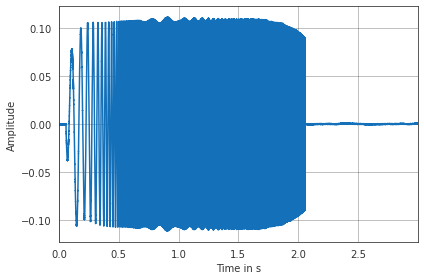

In [12]:
# plot reference-measurement in time domain
fig2 = pyfar.plot.line.time(x_ref)

<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

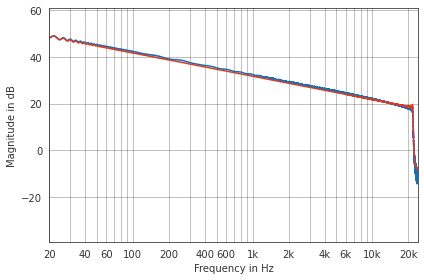

In [13]:
# plot sweep and reference-measurement in freq domain
fig3 = pyfar.plot.line.freq(x_ref)
pyfar.plot.line.freq(sweep)

In [22]:
# deconvolve reference-measurement with sweep to get a pyfar.Signal to add to Measurement Chain
H_ref = deconv(x_ref, sweep)
# add to Measurement Chain
chain.add_ref(H_ref, calibration=1, device_name='Sound Card')
# print names of devices in measurement chain
print(chain.ls_ref())

['Sound Card']


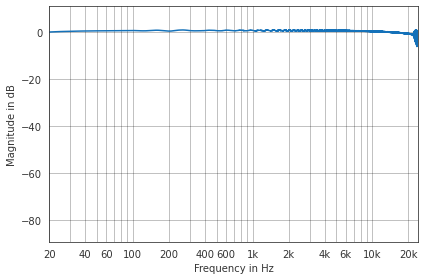

In [15]:
# plot freq-response of whole measurement chain
fig4 = pyfar.plot.line.freq(chain.get_refs())

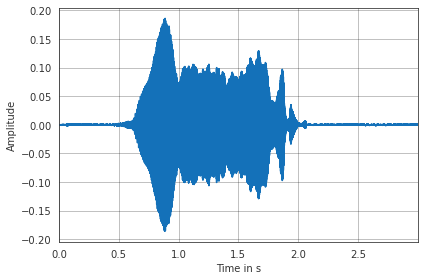

In [16]:
# plot measurement in time domain
fig5 = pyfar.plot.line.time(x_dut)

<AxesSubplot:xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

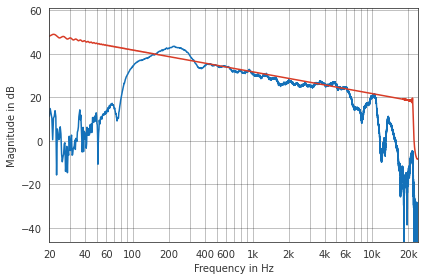

In [17]:
# plot sweep and reference-measurement in freq domain
fig6 = pyfar.plot.line.freq(x_dut)
pyfar.plot.line.freq(sweep)

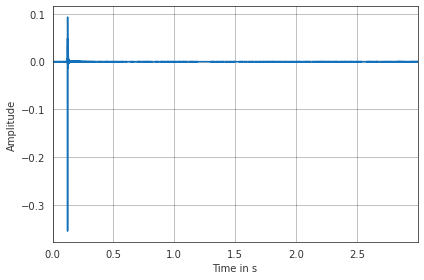

In [18]:
# deconvolve measurement with sweep to get a pyfar.Signal
H_dut = deconv(x_dut, sweep)

# multiply H_dut with freq-response of whole measurement chain to get pure DUT-data
H_dut = H_dut * chain.get_refs()

# plot IR of DUT
fig7 = pyfar.plot.line.time(H_dut)

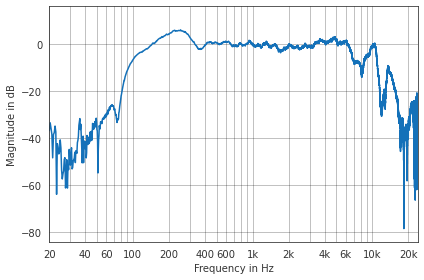

In [19]:
# plot frequency-response of DUT
fig8 = pyfar.plot.line.freq(H_dut)